In [1]:
import numpy
import matplotlib.pyplot as plt
import os

In [2]:
def plot_scatter(ypred,yval,ax=None):
    if ax is None:
        ax = plt.gca()
    
    
    # Scatterplot of predictions vs Labels
    ax.scatter(yval,ypred,label="Test",marker='+',zorder=2)
    ax.legend()
    ax.set_ylim([-1.5,1.5])
    ax.set_xlim([-1.5,1.5])
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
            ]
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.legend()
    ax.set_xlabel("Actual AMV Index")
    ax.set_ylabel("Predicted AMV Index")
    
    return ax

def calc_AMV_index(region,invar,lat,lon):
    """
    Select bounding box for a given AMV region for an input variable
        "SPG" - Subpolar Gyre
        "STG" - Subtropical Gyre
        "TRO" - Tropics
        "NAT" - North Atlantic
    
    Parameters
    ----------
    region : STR
        One of following the 3-letter combinations indicating selected region
        ("SPG","STG","TRO","NAT")
        
    var : ARRAY [Ensemble x time x lat x lon]
        Input Array to select from
    lat : ARRAY
        Latitude values
    lon : ARRAY
        Longitude values    

    Returns
    -------
    amv_index [ensemble x time]
        AMV Index for a given region/variable

    """
    
    # Select AMV Index region
    bbox_SP = [-60,-15,40,65]
    bbox_ST = [-80,-10,20,40]
    bbox_TR = [-75,-15,0,20]
    bbox_NA = [-80,0 ,0,65]
    regions = ("SPG","STG","TRO","NAT")        # Region Names
    bboxes = (bbox_SP,bbox_ST,bbox_TR,bbox_NA) # Bounding Boxes
    
    # Get bounding box
    bbox = bboxes[regions.index(region)]
    
    # Select Region
    selvar = invar.copy()
    klon = np.where((lon>=bbox[0]) & (lon<=bbox[1]))[0]
    klat = np.where((lat>=bbox[2]) & (lat<=bbox[3]))[0]
    selvar = selvar[:,:,klat[:,None],klon[None,:]]
    
    # Take mean ove region
    amv_index = np.nanmean(selvar,(2,3))
    
    return amv_index

def calculate_CESM_autocorrelation(detrend,nmembers=40,resolution='2deg'):
    # Calculate AMV Index Autocorrleation
    
    # Load in data [ens x yr x lat x lon]
    sst_normed = np.load('../../CESM_data/CESM_sst_normalized_lat_weighted_%s_NAT_Ann.npy' % (resolution)).astype(np.float32)
    lon = np.load("../../CESM_data/lon_%s_NAT.npy"%(resolution))
    lat = np.load("../../CESM_data/lat_%s_NAT.npy"%(resolution))
    
    # Detrend if set
    if detrend: # Remove ensemble average
        sst_normed = sst_normed - np.mean(sst_normed,axis=0)[None,:,:,:]
    
    # Calculate Autocorrelation
    tstep = 86
    lags  = 25
    sst_ensemble = calc_AMV_index('NAT',sst_normed[:,:,:,:],lat,lon)
    sst_lagged_corr = np.zeros((nmembers,lags))
    for lead in range(lags):
        sst_lead = sst_ensemble[:,lead:]
        sst_lag = sst_ensemble[:,0:tstep-lead]
        #sss_lag = sss_ensemble[:,0:tstep-lead]

        for ien in range(nmembers):
            sst_lagged_corr[ien,lead] = np.corrcoef( sst_lead[ien,:],sst_lag[ien,:] )[0,1]    
    sst_auto = sst_lagged_corr.copy()
    return sst_auto

In [3]:
#os.getcwd()

In [4]:
# User Edits
dirpath  = "/Users/gliu/Downloads/2020_Fall/6.862/Project/predict_amv/Analysis/"
os.chdir(dirpath)
datpath  = "../../CESM_data/Metrics/GRU_Test/"
outpath  = "../../CESM_data/Figures/GRU_Test/"
leads    = np.arange(0,25,3)

fn1 = "leadtime_testing_ALL_Ann224pix_NAT_simplecnn_nepoch20_nens40_lead08_GRU_sqlen10_lead24of24.npz"
fn2 = "leadtime_testing_ALL_Ann224pix_NAT_resnet50_nepoch20_nens40_lead08_GRU_sqlen10_lead24of24_Untuned.npz"
fn3 = "leadtime_testing_ALL_Ann224pix_NAT_resnet50_nepoch20_nens40_lead08_GRU_sqlen10_lead24of24_Tuned.npz"

files = (fn1,fn2,fn3)
expnames = ("CNN + GRU","Untuned ResNet50 + GRU", "Tuned ResNet50 + GRU")
expcolors = ("cornflowerblue","orange","green")

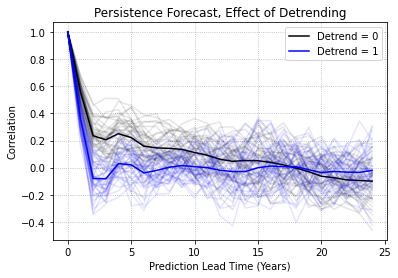

In [5]:
# Load baselines

# Calculate CESM Autocorrelation for detrend and no detrending cases
AUTO_corr = []
for i in [0,1]:
    AUTO_corr.append(calculate_CESM_autocorrelation(i))

# Plot Each One
colors = ['k','b']
fig,ax = plt.subplots(1,1)
for i in [0,1]:
    plotvar = AUTO_corr[i]
    for j in range(plotvar.shape[0]):
        ax.plot(plotvar[j],label="",alpha=0.1,color=colors[i])
    ax.plot(plotvar.mean(0),label="Detrend = %i"%i,color=colors[i])
ax.legend()
ax.grid(True,linestyle="dotted")
ax.set_title("Persistence Forecast, Effect of Detrending")
ax.set_ylabel("Correlation")
ax.set_xlabel("Prediction Lead Time (Years)")
plt.savefig(outpath+"Persistence_detrend.png",dpi=200)

In [6]:
# Examine .npz file to see the keys
ld = np.load(datpath+files[0],allow_pickle=True)
ld.files

['train_loss', 'test_loss', 'test_corr', 'yvalpred', 'yvallabels']

In [7]:
# Load data from each experiment and append

train_loss = []
test_loss  = []
test_corr  = []
yvalpred   = []
yvallabels = []

for i,fn in enumerate(files):
    fload = np.load(datpath+fn,allow_pickle=True)
    #print(fload.files)
    train_loss.append(fload['train_loss'])
    test_loss.append(fload['test_loss'])
    test_corr.append(fload['test_corr'])
    yvalpred.append(fload['yvalpred'])
    yvallabels.append(fload['yvallabels'])
    print("Loaded %s into position %i"%(fn,i))

Loaded leadtime_testing_ALL_Ann224pix_NAT_simplecnn_nepoch20_nens40_lead08_GRU_sqlen10_lead24of24.npz into position 0
Loaded leadtime_testing_ALL_Ann224pix_NAT_resnet50_nepoch20_nens40_lead08_GRU_sqlen10_lead24of24_Untuned.npz into position 1
Loaded leadtime_testing_ALL_Ann224pix_NAT_resnet50_nepoch20_nens40_lead08_GRU_sqlen10_lead24of24_Tuned.npz into position 2


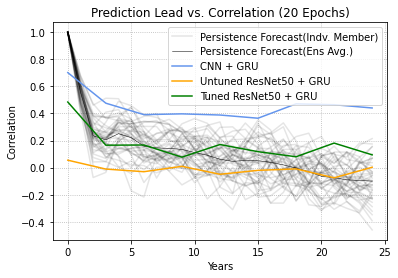

In [8]:


fig,ax = plt.subplots(1,1,figsize=(6,4))

i = 0
plotvar = AUTO_corr[i]
for j in range(plotvar.shape[0]):
    ax.plot(plotvar[j],label="",alpha=0.1,color=colors[i])
ax.plot(plotvar[-1],label="Persistence Forecast(Indv. Member)",color=colors[i],alpha=0.1)   
ax.plot(plotvar.mean(0),label="Persistence Forecast(Ens Avg.)",color=colors[i],lw=0.5)
    
for i in range(len(files)):
    ax.plot(leads,test_corr[i],label=expnames[i],color=expcolors[i])

ax.grid("True",linestyle="dotted")
ax.legend()
ax.set_xlabel("Years")
ax.set_ylabel("Correlation")
ax.set_title("Prediction Lead vs. Correlation (20 Epochs)")
plt.savefig(outpath+"GRU_test_results.png",dpi=200)


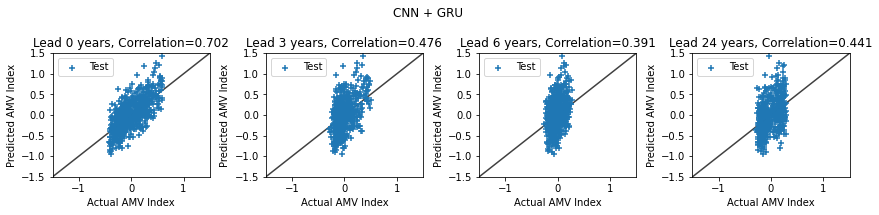

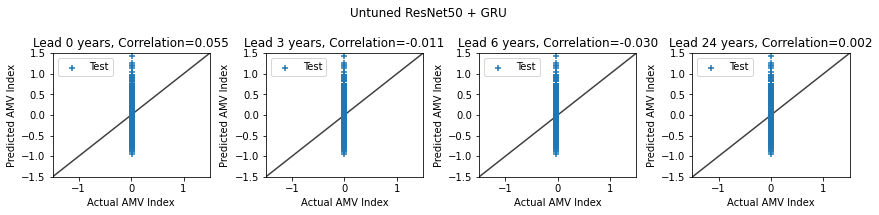

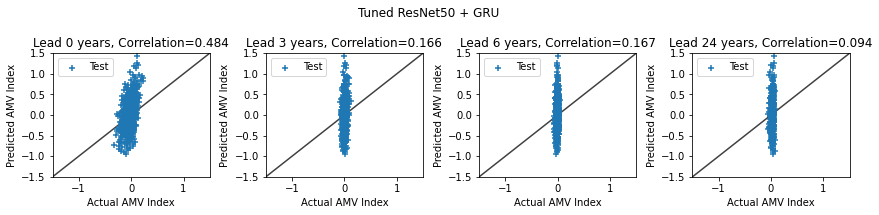

In [9]:
def lead_progression_scatter(leads,plotleads,yvallab,yvalpred,testcorr,figsize=(12,3)):
    """
    plotleads: ARRAY - Indices of the leads to plot
    
    """
    
    nleads = len(plotleads)
    fig,axs = plt.subplots(1,nleads,figsize=figsize)
    
    
    
    # Make Plots
    for i in range(nleads):
        
        klead = np.argwhere(leads==plotleads[i])[0][0]
        
        # Plot for ResNet50
        ax = axs[i]
        ax = plot_scatter(yvallab[klead],yvalpred[klead],ax=ax)
        ax.set_title("Lead %i years, Correlation=%.3f" % (plotleads[i],testcorr[klead]))

    plt.tight_layout()
    return fig,ax
    #plt.savefig(outpath+"ResNet50_Results_scatter.png",dpi=200)


for i,exp in enumerate(expnames):
    lead_progression_scatter(leads,[0,3,6,24],yvallabels[i],yvalpred[i],test_corr[i])
    plt.suptitle(exp)
    plt.tight_layout()

    plt.savefig(outpath+"GRU_%s_scatterplots.png"%(expnames[i]),dpi=200)

In [29]:
# Load data from each experiment and append

f21 = "leadtime_testing_ALL_Ann224pix_NAT_simplecnn_nepoch20_nens40_lead08_GRU_sqlen10_lead24of24_rerun.npz"
f22 = "leadtime_testing_ALL_Ann224pix_NAT_resnet50_nepoch20_nens40_lead08_GRU_sqlen10_lead24of24_rerun.npz"
f23 = "leadtime_testing_ALL_Ann224pix_NAT_resnet18_nepoch20_nens40_lead08_GRU_sqlen10_lead24of24.npz"
files2 = [f21,f22,f23]
expnames2 = ['Simple CNN + GRU',"ResNet50 (Last Layer Unfrozen) + GRU","ResNet18 (All Layers Unfrozen) + GRU"]
train_loss2 = []
test_loss2  = []
test_corr2  = []
yvalpred2   = []
yvallabels2 = []

for i,fn in enumerate(files2):
    fload = np.load(datpath+fn,allow_pickle=True)
    #print(fload.files)
    train_loss2.append(fload['train_loss'])
    test_loss2.append(fload['test_loss'])
    test_corr2.append(fload['test_corr'])
    yvalpred2.append(fload['yvalpred'])
    yvallabels2.append(fload['yvallabels'])
    print("Loaded %s into position %i"%(fn,i))

Loaded leadtime_testing_ALL_Ann224pix_NAT_simplecnn_nepoch20_nens40_lead08_GRU_sqlen10_lead24of24_rerun.npz into position 0
Loaded leadtime_testing_ALL_Ann224pix_NAT_resnet50_nepoch20_nens40_lead08_GRU_sqlen10_lead24of24_rerun.npz into position 1
Loaded leadtime_testing_ALL_Ann224pix_NAT_resnet18_nepoch20_nens40_lead08_GRU_sqlen10_lead24of24.npz into position 2


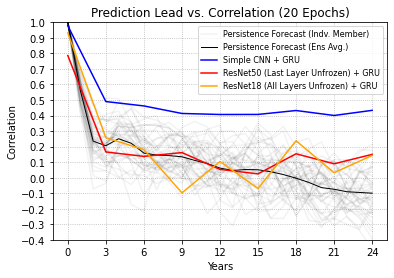

In [31]:


colors2 = ['b','r','orange']
fig,ax = plt.subplots(1,1,figsize=(6,4))

i = 0
plotvar = AUTO_corr[i]
for j in range(plotvar.shape[0]):
    ax.plot(plotvar[j],label="",alpha=0.05,color='k')
ax.plot(plotvar[-1],label="Persistence Forecast (Indv. Member)",color='k',alpha=0.05)   
ax.plot(plotvar.mean(0),label="Persistence Forecast (Ens Avg.)",color='k',lw=1)
    
for i in range(len(files2)):
    ax.plot(leads,test_corr2[i],label=expnames2[i],color=colors2[i])

ax.grid("True",linestyle="dotted")
ax.set_yticks(np.arange(-0.4,1.1,.1))
ax.set_xticks(np.arange(0,25,3))
ax.set_ylim([-.4,1])
ax.legend(fontsize=8)
ax.set_xlabel("Years")
ax.set_ylabel("Correlation")
ax.set_title("Prediction Lead vs. Correlation (20 Epochs)")
plt.savefig(outpath+"GRU_test_results_Rerun.png",dpi=200)


In [42]:
# Read in data for GRU 1200 epoch test

fn1 = "/Users/gliu/Downloads/2020_Fall/6.862/Project/CESM_data/Metrics/epoch1200/leadtime_testing_ALL_Ann224pix_NAT_resnet50_nepoch1200_nens40_lead00_GRU_sqlen10_lead24of24.npz"

fload = np.load(fn1,allow_pickle=True)
#print(fload.files)
#fload['train_loss'])
gru_loss2=fload['test_loss']
corr_grid_test = fload['test_corr']
y_pred_val = fload['yvalpred']
y_valdt = fload['yvallabels']
#print("Loaded %s into position %i"%(fn,i))

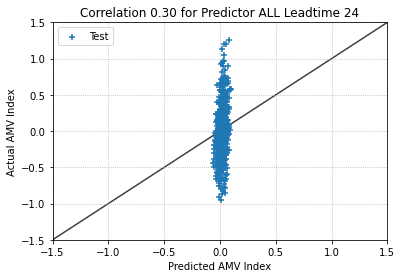

In [41]:


fig,ax=plt.subplots(1,1)
 
ax.scatter(y_pred_val,y_valdt,label="Test",marker='+',zorder=2)
ax.legend()
ax.set_ylim([-1.5,1.5])
ax.set_xlim([-1.5,1.5])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
        ]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.legend()
ax.set_ylabel("Actual AMV Index")
ax.set_xlabel("Predicted AMV Index")
ax.grid(True,linestyle="dotted")
ax.set_title("Correlation %.2f for Predictor %s Leadtime %i"%(corr_grid_test[0],'ALL',24))
#plt.show()
plt.savefig("../../CESM_data/Figures/%s_%s_leadnum%s_ValidationScatter.png"%("epoch1200_GRURN50","ALL",24))


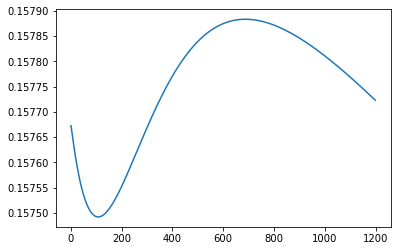

In [49]:
plt.plot(gru_loss2[0])

In [50]:
gru_loss2.argmin()

107

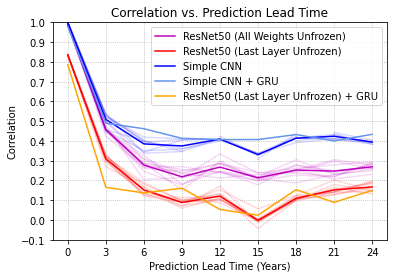

In [57]:
path   = "/Users/gliu/Downloads/2020_Fall/6.862/Project/CESM_data/Metrics/10runtest/"
outfigpath = "/Users/gliu/Downloads/2020_Fall/6.862/Project/CESM_data/Figures/10runtest/"
nruns  = 10 
nleads = 9
leads = np.arange(0,25,3)
#%%
# Read in the ResNet Results
trainlosses = np.zeros([2,nruns,20,9])
testlosses  = np.zeros([2,nruns,20,9])
testcorrs   = np.zeros([2,nruns,9])
ypreds = []
ylabs = []
# ypreds      = np.zeros([2,nruns,9,664])
# ylabs       = np.zeros([2,nruns,9,664])
for f,freeze in enumerate([True,False]):
    fpred = []
    flab = []
    for i in range(nruns):
        # ['train_loss', 'test_loss', 'test_corr', 'yvalpred', 'yvallabels']
        searchterm = "leadtime_testing_ALL_HPT_resnet50_nepoch20_nens40_maxlead24_detrend0_noise0_unfreeze_all%s_run%i_ALL.npz" % (freeze,i)
        ld = np.load(path+searchterm,allow_pickle=True)
        trainloss = ld['train_loss']
        testloss = ld['test_loss'] # [20,9]
        testcorr = ld['test_corr']  # [9x]
        ypred = ld['yvalpred'] # [9,]
        ylab = ld['yvallabels'] # [9][0] 688
        
        trainlosses[f,i,:,:] = trainloss
        testlosses[f,i,:,:] = testloss
        testcorrs[f,i,:] = testcorr
        
        fpred.append(ypred)
        flab.append(ylab)
        # for l in range(9):
        #     ypreds[f,i,l,:]=ypred[l]
        #     ylabs[f,i,l,:]=ylab[l]
    ypreds.append(fpred)
    ylabs.append(flab)


#%%
# Read in the simplecnn results
ctrainlosses = np.zeros([2,nruns,20,9])
ctestlosses  = np.zeros([2,nruns,20,9])
ctestcorrs   = np.zeros([2,nruns,9])
cypreds = []
cylabs = []
# ypreds      = np.zeros([2,nruns,9,664])
# ylabs       = np.zeros([2,nruns,9,664])
for f,freeze in enumerate([True,False]):
    fpred = []
    flab = []
    for i in range(nruns):
        # ['train_loss', 'test_loss', 'test_corr', 'yvalpred', 'yvallabels']
        searchterm = "leadtime_testing_ALL_HPT_simplecnn_nepoch20_nens40_maxlead24_detrend0_noise0_cnndropout%s_run%i_ALL.npz" % (freeze,i)
        ld = np.load(path+searchterm,allow_pickle=True)
        trainloss = ld['train_loss']
        testloss = ld['test_loss'] # [20,9]
        testcorr = ld['test_corr']  # [9x]
        ypred = ld['yvalpred'] # [9,]
        ylab = ld['yvallabels'] # [9][0] 688
        
        ctrainlosses[f,i,:,:] = trainloss
        ctestlosses[f,i,:,:] = testloss
        ctestcorrs[f,i,:] = testcorr
        
        fpred.append(ypred)
        flab.append(ylab)
        # for l in range(9):
        #     ypreds[f,i,l,:]=ypred[l]
        #     ylabs[f,i,l,:]=ylab[l]
    cypreds.append(fpred)
    cylabs.append(flab)


colors2=['cornflowerblue','orange','gold']
#%%
# Make some correlation plots
fig,ax = plt.subplots(1,1)

ax.plot(leads,testcorrs[0,:,:].T, label="",color='m',alpha=0.15)
ax.plot(leads,testcorrs[0,:,:].mean(0), label="ResNet50 (All Weights Unfrozen)",color='m',alpha=1)

ax.plot(leads,testcorrs[1,:,:].T, label="",color='r',alpha=0.15)
ax.plot(leads,testcorrs[1,:,:].mean(0), label="ResNet50 (Last Layer Unfrozen)",color='r',alpha=1)

ax.plot(leads,ctestcorrs[1,:,:].T, label="",color='b',alpha=0.15)
ax.plot(leads,np.nanmean(ctestcorrs[1,:,:],0), label="Simple CNN",color='b',alpha=1)

for i in range(len(files2)-1):
    ax.plot(leads,test_corr2[i],label=expnames2[i],color=colors2[i])
    
# ax.plot(leads,ctestcorrs[0,:,:].T, label="",color='cornflowerblue',alpha=0.15)
# ax.plot(leads,np.nanmean(ctestcorrs[0,:,:],0), label="Simple CNN (without Dropout)",color='cornflowerblue',alpha=1)

# ax.plot(leads,ctestcorrs[0,:,:].T, label="",color='m',alpha=0.15)
# ax.plot(leads,np.nanmean(ctestcorrs[0,:,:],0), label="CNN (With Dropout)",color='yellow',alpha=1)

ax.legend()
ax.set_yticks(np.arange(-0.1,1.1,.1))
ax.set_xticks(np.arange(0,25,3))
ax.set_ylim([-.1,1])
ax.grid(True,ls='dotted')
ax.set_ylabel("Correlation")
ax.set_xlabel("Prediction Lead Time (Years)")
ax.set_title("Correlation vs. Prediction Lead Time")
plt.savefig(outfigpath+"ResNet_WeightFreeze_Comparison",dpi=200)